# <b>CSYE7380 39495 Theory & Prac App AI Gen Model Spring 2024 <b> #
### Week 3 Assignment <br> ###
Student: Shen Wang <br>
NUID: 002697074<br>
wang.shen3@northeastern.edu <br>
Instructor: Professor Subrata Das<br>
submission date: 30 Jan, 2024 <br>

This assignment is based on the tutorial available at: <br>
https://www.analyticsvidhya.com/blog/2022/09/how-to-classify-the-images-of-the-cifar-10-dataset-using-cnn/ <br>

Classify CIFAR 10 images (download from the Internet) with a CNN model but study the effect on the performance by varying the following modeling aspects:

1) Batch Normalization

2) Dropout

3) Number of convolution and pooling layers

4) Activation functions

Prepare about six slides on the findings describing the problem, approach, and the findings.


### Part 1. CNN tutorial  <br> ###
1.1 CIFAR-10 Photo Classification Dataset
CIFAR ( Canadian Institute For Advanced Research)-10 dataset is a collection of 60000 32px * 32px color images that are of 10 different classes.
The class labels and their standard associated integer values are listed below.

    0: airplane
    1: automobile
    2: bird
    3: cat
    4: deer
    5: dog
    6: frog
    7: horse
    8: ship
    9: truck

 the dataset was intended for computer vision research.

 To save time, we choose 4 classes out of these 10:
 
    1: automobile
    3: cat
    5: dog
    9: truck


In [1]:
import pickle
import numpy as np
import os
import matplotlib.pyplot as plt

def unpickle(file):
    with open(file, 'rb') as fo:
        dict = pickle.load(fo, encoding='bytes')
    return dict


def load_cifar10_data(data_dir):
    train_data = None
    train_labels = []

    for i in range(1, 6):
        data_dic = unpickle(data_dir + "/data_batch_{}".format(i))
        if i == 1:
            train_data = data_dic[b'data']
        else:
            train_data = np.vstack((train_data, data_dic[b'data']))
        train_labels += data_dic[b'labels']

    test_data_dic = unpickle(data_dir + "/test_batch")
    test_data = test_data_dic[b'data']
    test_labels = test_data_dic[b'labels']

    train_data = train_data.reshape((len(train_data), 3, 32, 32))
    train_data = np.rollaxis(train_data, 1, 4)
    train_labels = np.array(train_labels)

    test_data = test_data.reshape((len(test_data), 3, 32, 32))
    test_data = np.rollaxis(test_data, 1, 4)
    test_labels = np.array(test_labels)

    # Filter the data based on the labels
    selected_classes = [1, 3, 5, 9]
    train_mask = np.isin(train_labels, selected_classes)
    test_mask = np.isin(test_labels, selected_classes)

    train_data, train_labels = train_data[train_mask], train_labels[train_mask]
    test_data, test_labels = test_data[test_mask], test_labels[test_mask]

    return (train_data, train_labels), (test_data, test_labels)

# load dataset
data_dir = './cifar-10-batches-py' # update the path to where cifar-10-python.tar.gz is extracted

(trainX, trainy), (testX, testy) = load_cifar10_data(data_dir)

# summarize loaded dataset
print('Train: X=%s, y=%s' % (trainX.shape, trainy.shape))
print('Test: X=%s, y=%s' % (testX.shape, testy.shape))
print('There are %d classes, which are %s' %(len(set(trainy)), set(trainy)))


Train: X=(20000, 32, 32, 3), y=(20000,)
Test: X=(4000, 32, 32, 3), y=(4000,)
There are 4 classes, which are {9, 3, 5, 1}


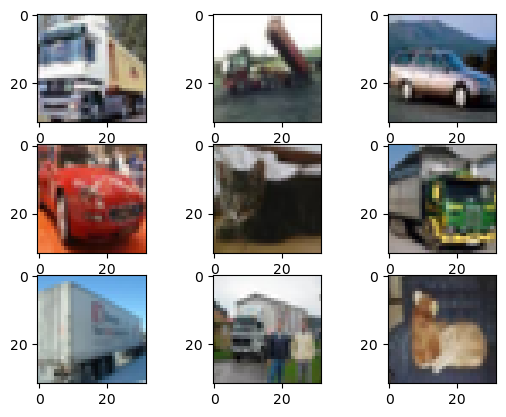

In [2]:
# plot first few images
for i in range(9):
    # define subplot
    # plt.subplot(330 + 1 + i)
    # plot raw pixel data
    plt.subplot(3,3,i+1)
    plt.imshow(trainX[i])
# show the figure
plt.show()

# the images are indeed very small compared to modern photographs; 
# it can be challenging to see what exactly is represented in some 
# of the images given the extremely low resolution.

# This low resolution is likely the cause of the limited performance 
# that top-of-the-line algorithms are able to achieve on the dataset.

### Part 1.1  Develop a Baseline Model ###

A baseline model will establish a minimum model performance to which all of our other models can be compared, as well as a model architecture that we can use as the basis of study and improvement.

We will use the general architectural principles of the VGG models as the baseline model.

The architecture involves stacking convolutional layers with small 3×3 filters followed by a max pooling layer. Together, these layers form a block, and these blocks can be repeated where the number of filters in each block is increased with the depth of the network such as 32, 64, 128, 256 for the first four blocks of the model. Padding is used on the convolutional layers to ensure the height and width of the output feature maps matches the inputs.

We can define three different model architectures with 1, 2, and 3 VGG modules

1.1.1 one hot encoding of the classes

In [3]:
# The tutorial developed a test harness with five key elements. 
# They are 
#   the loading of the dataset, 
#   the preparation of the dataset, 
#   the definition of the model, 
#   the evaluation of the model, 
#   the presentation of results.

#   The dataset:
#     We also know that there are 10 classes and that classes are represented as unique integers.
#     We can use a one hot encoding for the class element of each sample, transforming the integer 
#     into a 10 element binary vector with a 1 for the index of the class value. We can achieve this 
#     with the to_categorical() utility function.
from keras.utils import to_categorical
def load_dataset():
  # load dataset
  (trainX, trainY), (testX, testY) = load_cifar10_data(data_dir)
  # one hot encode target values
  # Map the labels to a new range [0-3] because to_categorical treats the labels as indices
  mapping = {1: 0, 3: 1, 5: 2, 9: 3}
  trainY = np.vectorize(mapping.get)(trainY)
  testY = np.vectorize(mapping.get)(testY)
  
  # one hot encode target values
  trainY = to_categorical(trainY, num_classes=4)
  testY = to_categorical(testY, num_classes=4)
  return (trainX, trainY), (testX, testY)

(trainX, trainY), (testX, testY) = load_dataset()
testY

d:\anaconda3\lib\site-packages\scipy\__init__.py:146: UserWarning: A NumPy version >=1.16.5 and <1.23.0 is required for this version of SciPy (detected version 1.26.3
  warnings.warn(f"A NumPy version >={np_minversion} and <{np_maxversion}"


array([[0., 1., 0., 0.],
       [1., 0., 0., 0.],
       [0., 1., 0., 0.],
       ...,
       [0., 1., 0., 0.],
       [0., 0., 1., 0.],
       [1., 0., 0., 0.]], dtype=float32)

1.1.2 normalize the input pixel values

In [4]:
# This function must be called to prepare the pixel values prior to any modeling.
def prep_pixels(train, test):
  return train.astype('float32')/255.0, test.astype('float32')/255.0

1.1.3 define cnn model

In [5]:
from keras.models import Sequential
def define_model():
  model = Sequential()
  return model

model=define_model()

# In Keras, a model is a way to organize layers. 
# The Sequential class in Keras is a linear stack of layers. 
# You can think of it as a simple type of model 
# where you can add one layer at a time in a linear manner, 
# from input to output
# When we do model = Sequential(), 
# we’re creating an empty Sequential model with no layers. 
# This is why it’s considered as “no model” at this point. 
# We need to add layers to this model for it to be able to learn from data.

1.1.4 Evaluate the Model

In [6]:
# Fitting the model will require that the number of training epochs and batch size to be specified. 
# The tutorial uses a generic 100 training epochs for now and a modest batch size of 64.

# fit the model
# history = model.fit(trainX,trainY, epochs=100, batch_size=64, validation_data=(testX,testY),verbose=0)

# evaluate the model
# _, acc = model.evaluate(testX, testY, verbose=0)

1.1.5 Present Results

In [7]:
# There are two key aspects to present: 
#   the diagnostics of the learning behavior of the model during training
#   the estimation of the model performance.
import sys

def summarize_diagnostics(history):
  # plot loss
  plt.subplot(2,1,1)
  plt.title('Cross Entropy Loss')
  plt.plot(history.history['loss'], color='blue', label='train')
  plt.plot(history.history['val_loss'], color='orange', label='test')
  # plot accuracy
  plt.subplot(2,1,2)
  plt.title('Classification Accuracy')
  plt.plot(history.history['accuracy'], color='blue', label='train')
  plt.plot(history.history['val_accuracy'], color='orange', label='test')
  # show the plot
  plt.show()




1.1.6 Complete test harness for evaluating a model


In [8]:
def run_test_harness():
  # load dataset
  (trainX, trainY), (testX, testY) = load_dataset()
  # prepare pixel data
  trainX, testX = prep_pixels(trainX, testX)
  # define model
  model = define_model()
  # fit model
  history = model.fit(trainX, trainY, epochs = 100, batch_size = 64, validation_data=(testX, testY), verbose=0)
  # evaluate model
  _, acc = model.evaluate(testX, testY, verbose=0)
  print('> %.3f' % (acc*100.0))
  # learning curves
  summarize_diagnostics(history)


The above is the base structure of a model.

Now we can add some layers to the model to let it process the dataset.

#### 1.2 3 Baseline models ####

In [9]:
# 1VGG Block
import sys
from keras.models import Sequential
from keras.layers import Conv2D, MaxPooling2D, Flatten, Dense
from keras.optimizers import SGD

# The function define_model() returns the configured model. 
# This model can then be trained using the fit() function in Keras.
def define_model():
  # define cnn model
  # This initializes a linear stack of layers 
  # which we can sequentially add to
  model = Sequential()
  # This adds a 2D convolution layer with 32 filters, 
  # a kernel size of 3x3, ‘relu’ activation function, 
  # ‘he_uniform’ method for weight initialization, 
  # ‘same’ padding (input width and height are preserved), 
  # and an input shape of 32x32x3 (for color images of size 32x32 with 3 channels: Red, Green, Blue)
  model.add(Conv2D(32,(3,3), activation='relu', kernel_initializer='he_uniform', padding='same', input_shape=(32,32,3)))
  # This adds another 2D convolution layer with the same parameters 
  # but without the need to specify the input shape
  model.add(Conv2D(32,(3,3), activation='relu', kernel_initializer='he_uniform', padding='same'))
  # This adds a max pooling layer that transforms the input 
  # by taking the maximum value over 2x2 windows to reduce the spatial dimensions
  model.add(MaxPooling2D((2,2)))
  # This layer flattens the multi-dimensional tensor into a one-dimensional tensor 
  # so it can be fed into the fully connected (dense) layers
  model.add(Flatten())
  # This adds a dense layer (fully connected layer) with 128 neurons, 
  # ‘relu’ activation function, and ‘he_uniform’ method for weight initialization
  model.add(Dense(128, activation='relu', kernel_initializer='he_uniform'))
  # This adds the output layer which is also a dense layer with 10 neurons 
  # (for 10 classes of output) and ‘softmax’ activation function 
  # which makes the output sum up to 1 so it can be interpreted as probabilities
  model.add(Dense(4, activation='softmax'))
  # compile model
  # This initializes the Stochastic Gradient Descent optimizer 
  # with a learning rate of 0.001 and momentum of 0.9
  opt = SGD(lr=0.001, momentum=0.9)
  # This configures the model for training with the specified optimizer, loss function, and metrics. 
  # The loss function used is ‘categorical_crossentropy’ which is suitable for multi-class classification. 
  # The metric used is ‘accuracy’ which calculates how often predictions equal labels
  model.compile(optimizer=opt, loss='categorical_crossentropy',metrics=['accuracy'])
  return model



            

> 77.475


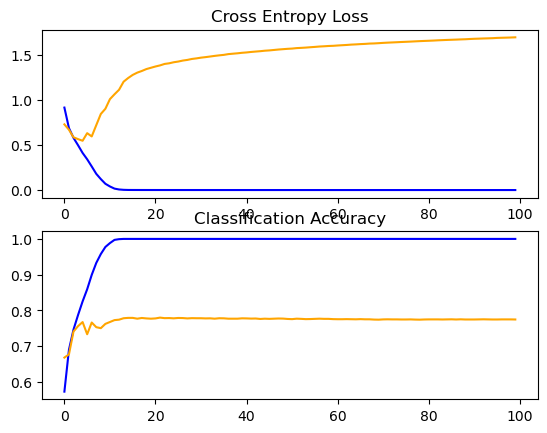

In [10]:
# run the 1VGG model we just built
run_test_harness()

##### Question: Why is this model called 1VGG? #####

ChatGPT answer: 

The model is referred to as “1VGG” because it appears to be a simplified version of the VGG (Visual Geometry Group) architecture, which is a deep Convolutional Neural Network (CNN) developed by the Visual Geometry Group at the University of Oxford1.

The original VGG models, such as VGG16 and VGG19, are named for their depth, with 16 and 19 layers respectively1. These models are known for their use of small (3x3) convolutional filters and deep stacks of layers to achieve high performance on image recognition tasks1.

In the case of the “1VGG” model you’ve posted, it seems to be a single “block” of the VGG architecture, containing just one stack of Conv2D and MaxPooling2D layers. Hence, it might be referred to as “1VGG” to indicate that it’s a simplified, single-block version of the original VGG models. However, please note that “1VGG” is not a standard term in the literature, and its usage may vary.

##### Question: Why are there 32 convolutional filters in the 1VGG model's 1st Conv2D layer? #####

ChatGPT answer:

The number of filters in a Conv2D layer determines the number of feature maps that the layer will learn from the input data. Each filter is responsible for learning different features from the input. For example, one filter might learn to detect edges, while another might learn to detect a particular color12.

In this case, the Conv2D layer has 32 filters, which means it will learn 32 different feature maps from the input data. The choice of 32 is somewhat arbitrary and is often determined through experimentation. It’s common to start with a relatively small number of filters in the initial layers and then increase the number of filters in deeper layers12.

The filters in the first few layers are usually less abstract and typically emulate edge detectors, blob detectors, etc. You generally don’t want too many filters applied to the input layer as there is only so much information extractable from the raw input layer. Most of the filters will be redundant if you add too many3.

It’s important to note that these filters are initialized with small random values and are updated during the training process to minimize the loss function2. This means that the network learns what features to extract from the data during training.

##### Analysis of Baseline model 1VGG: #####

From the result above, we saw that the baseline model has a general accuracy of 77.475%. 
And the resultant graphs shows the history of the fitting. 
The graph above shows the variation of the loss function, and the graph below shows the accuracy.
The blue curves apply to the training dataset, while the orange curves apply to the validation dataset, or say, the test dataset, in our case.

We observe that the blue curves run to a platform stage at about the 15th epoch. The rest of the 85 epochs are just overfitting to the training dataset. Meanwhile, the accuracy of the model in the validation dataset remains as low as 65% for most of the time, and the loss function keeps increasing. 

This shows the limitation of the baseline model, and at the same time the potential of improvement.

### Part 2, Improving the Baseline Model ###

2.1 Batch Normalization

Batch Normalization is a technique used to standardize the inputs to a network, applied to either the activations of a prior layer or inputs directly1. It accelerates training, in some cases by halving the epochs or better, and provides some regularization, reducing generalization error1.

In Keras, we can apply batch normalization to our model using the BatchNormalization layer.


> 78.875


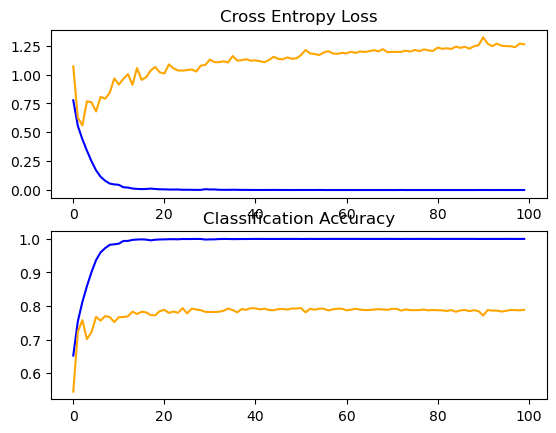

In [12]:
from keras.layers import BatchNormalization
import sys

def define_model():
  model = Sequential()
  model.add(Conv2D(32,(3,3), activation='relu', kernel_initializer='he_uniform', padding='same', input_shape=(32,32,3)))
  # add batch normalization
  model.add(BatchNormalization())
  model.add(Conv2D(32,(3,3), activation='relu', kernel_initializer='he_uniform', padding='same'))
  # add batch normalization
  model.add(BatchNormalization())
  model.add(MaxPooling2D((2,2)))
  model.add(Flatten())
  model.add(Dense(128, activation='relu', kernel_initializer='he_uniform'))
  # add batch normalization
  model.add(BatchNormalization())
  model.add(Dense(4, activation='softmax'))
  opt = SGD(lr=0.001, momentum=0.9)
  model.compile(optimizer=opt, loss='categorical_crossentropy',metrics=['accuracy'])
  return model

# run the improved model
run_test_harness()

Analysis of Batch Normalization:

Batch Normalization is a common improvement to Convolutional Neural Network. It is usually applied to the output of convolutional layer before the activation function is applied. By normalizing the output, the network could become more stable, and it also brought in fluctuation to the data, which allows the model to avoid local minimum during the optimization.

In our experiment above, the batch normalization raised the accuracy of the model to 78.875%, (from 77.475%, by 1.4%). 
And we also observed that though there is a quick overfit to the training data at about the 15th epoch, the testing on the test data is not stalled, but shows fluctuation as well. 

2.2 Dropout

Dropout is a simple technique that will randomly drop nodes out of the network. It has a regularizing effect as the remaining nodes must adapt to pick-up the slack of the removed nodes.

Dropout can be added to the model by adding new Dropout layers, where the amount of nodes removed is specified as a parameter. There are many patterns for adding Dropout to a model, in terms of where in the model to add the layers and how much dropout to use.

In [13]:
from keras.layers import Dropout
def define_model():
  model = Sequential()
  model.add(Conv2D(32, (3, 3), activation='relu', kernel_initializer='he_uniform', padding='same', input_shape=(32, 32, 3)))
  model.add(Conv2D(32, (3, 3), activation='relu', kernel_initializer='he_uniform', padding='same'))
  model.add(MaxPooling2D((2, 2)))
  # adding dropout layer to model
  model.add(Dropout(0.2))
  model.add(Conv2D(64, (3, 3), activation='relu', kernel_initializer='he_uniform', padding='same'))
  model.add(Conv2D(64, (3, 3), activation='relu', kernel_initializer='he_uniform', padding='same'))
  model.add(MaxPooling2D((2, 2)))
  # adding dropout layer to model
  model.add(Flatten())
  model.add(Dense(128, activation='relu', kernel_initializer='he_uniform'))
  model.add(Dropout(0.2))
  model.add(Dense(4, activation='softmax'))
  # compile model
  opt = SGD(lr=0.001, momentum=0.9)
  model.compile(optimizer=opt, loss='categorical_crossentropy', metrics=['accuracy'])
  return model

> 83.300


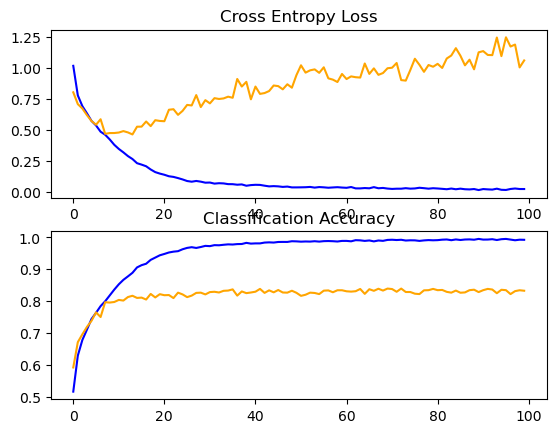

In [14]:
# run the improved model
run_test_harness()

Analysis of dropout

Dropout is a regularization technique used in Convolutional Neural Networks (CNNs) to prevent overfitting.

It randomly “drop” units: During training, dropout randomly selects a subset of neurons and temporarily removes them along with all their incoming and outgoing connections. This means these dropped out neurons do not contribute to the forward pass and do not participate in backpropagation. Each neuron has a preset chance of being excluded from the network in each training round. This process creates a different network architecture at each training step, simulating the effect of training a large number of different network architectures, to introduce fluctuations to the model.

We added dropout layer between convolution layers and fully connected layers, also, fully connected layers and output layers, to introduce fluctuation to the model. 

The accuracy was significantly raised to 83.3% from 77.475%, (by 5.825%)

We also observed that the convergence of the model is now slowing down, showing the effect of supressing overfitting.

2.3 Number of convolution and pooling layers

The simplified VGG (Visual Geometry Group) architecture involves stacking convolutional layers with small 3×3 filters followed by a max pooling layer. Together, these layers form a block, and these blocks can be repeated where the number of filters in each block is increased with the depth of the network such as 32, 64, 128, 256 for the first four blocks of the model. The increase of filters is an empirical knowledge. Padding is used on the convolutional layers to ensure the height and width of the output feature maps matches the inputs.

We can explore this architecture on the CIFAR-10 problem and compare a model with this architecture with 1, 2, and 3 blocks, or, in another word, a model with 1, 2 and 3 folds of convoltion and pooling layers.

> 80.300


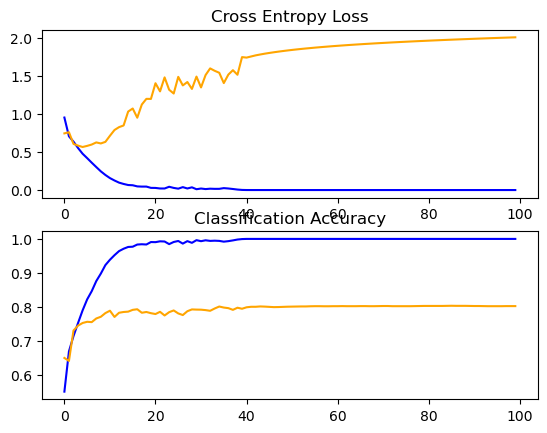

In [17]:
# 2 blocks
def define_model():
  model = Sequential()
  # 1st block
  model.add(Conv2D(32, (3, 3), activation='relu', kernel_initializer='he_uniform', padding='same', input_shape=(32, 32, 3)))
  model.add(Conv2D(32, (3, 3), activation='relu', kernel_initializer='he_uniform', padding='same'))
  model.add(MaxPooling2D((2, 2)))
  # 2nd block
  model.add(Conv2D(64, (3, 3), activation='relu', kernel_initializer='he_uniform', padding='same'))
  model.add(Conv2D(64, (3, 3), activation='relu', kernel_initializer='he_uniform', padding='same'))
  model.add(MaxPooling2D((2, 2)))
  # adding dropout layer to model
  model.add(Flatten())
  model.add(Dense(128, activation='relu', kernel_initializer='he_uniform'))
  model.add(Dense(4, activation='softmax'))
  # compile model
  opt = SGD(lr=0.001, momentum=0.9)
  model.compile(optimizer=opt, loss='categorical_crossentropy', metrics=['accuracy'])
  return model    

# run the improved model
run_test_harness()     

> 82.100


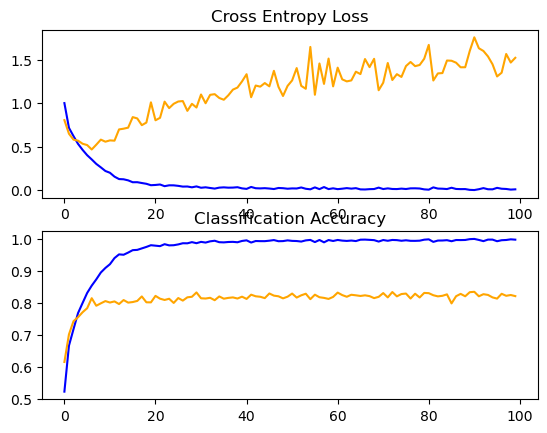

In [18]:
# 3 blocks
def define_model():
  model = Sequential()
  # 1st block
  model.add(Conv2D(32, (3, 3), activation='relu', kernel_initializer='he_uniform', padding='same', input_shape=(32, 32, 3)))
  model.add(Conv2D(32, (3, 3), activation='relu', kernel_initializer='he_uniform', padding='same'))
  model.add(MaxPooling2D((2, 2)))
  # 2nd block
  model.add(Conv2D(64, (3, 3), activation='relu', kernel_initializer='he_uniform', padding='same'))
  model.add(Conv2D(64, (3, 3), activation='relu', kernel_initializer='he_uniform', padding='same'))
  model.add(MaxPooling2D((2, 2)))
  # 3rd block
  model.add(Conv2D(128, (3, 3), activation='relu', kernel_initializer='he_uniform', padding='same'))
  model.add(Conv2D(128, (3, 3), activation='relu', kernel_initializer='he_uniform', padding='same'))
  model.add(MaxPooling2D((2, 2)))
  # flatten the model
  model.add(Flatten())
  model.add(Dense(128, activation='relu', kernel_initializer='he_uniform'))
  model.add(Dense(4, activation='softmax'))
  # compile model
  opt = SGD(lr=0.001, momentum=0.9)
  model.compile(optimizer=opt, loss='categorical_crossentropy', metrics=['accuracy'])
  return model    

# run the improved model
run_test_harness()           

Analysis on blocks

Adding blocks is gradually improving the overall accuracy of the model. 

Compared to our baseline model with single block, 2 blocks of convolutional layer + pooling layer bloacks increased the accuracy of the model to 80.3% (by 2.825%), and 3 blocks improves the accuracy to 82.1% (by 4.625%)

And we also observed that the convergence of the model is significantly suppressed which helps the model to avoid overfitting.


2.4. Activation functions

We can choose sigmoid activation function instead of relu activation function.


> 73.900


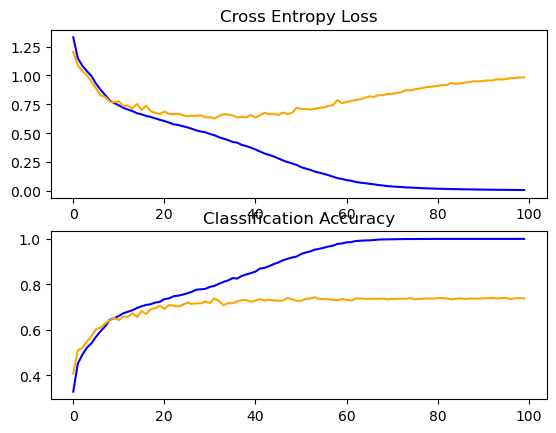

In [19]:
# 2 blocks
def define_model():
  model = Sequential()
  model.add(Conv2D(32, (3, 3), activation='sigmoid', kernel_initializer='he_uniform', padding='same', input_shape=(32, 32, 3)))
  model.add(Conv2D(32, (3, 3), activation='sigmoid', kernel_initializer='he_uniform', padding='same'))
  model.add(MaxPooling2D((2, 2)))
  # flatten the model
  model.add(Flatten())
  model.add(Dense(128, activation='sigmoid', kernel_initializer='he_uniform'))
  model.add(Dense(4, activation='softmax'))
  # compile model
  opt = SGD(lr=0.001, momentum=0.9)
  model.compile(optimizer=opt, loss='categorical_crossentropy', metrics=['accuracy'])
  return model    

# run the improved model
run_test_harness()   

Analysis of sigmoid activation function:

We can observe that sigmoid function allows the model to converge slower, hence supress overfitting. 
But its overall accuracy is not as good as "relu" function. The overall accuracy dropped to 73.9% from 77.475%, by -3.575%.

2.5 put all of them together

    1. 3 blocks 
    2. dropout
    3. BatchNormalization
    4. sigmoid activation function

> 88.025


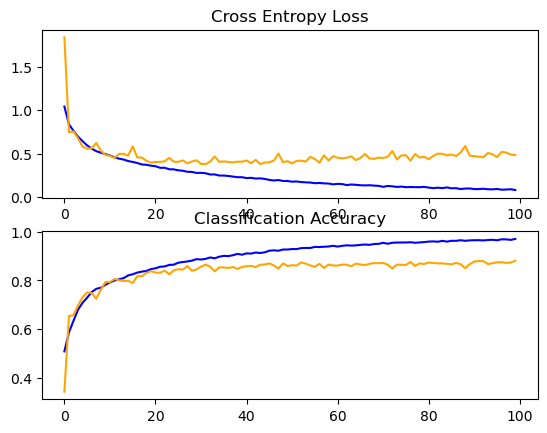

In [21]:
from keras.layers import Dropout

def define_model():
  model = Sequential()
  
  # First block
  model.add(Conv2D(32, (3,3), activation='sigmoid', kernel_initializer='he_uniform', padding='same', input_shape=(32,32,3)))
  model.add(BatchNormalization())
  model.add(Conv2D(32, (3,3), activation='sigmoid', kernel_initializer='he_uniform', padding='same'))
  model.add(BatchNormalization())
  model.add(MaxPooling2D((2,2)))
  model.add(Dropout(0.2))

  # Second block
  model.add(Conv2D(64, (3,3), activation='sigmoid', kernel_initializer='he_uniform', padding='same'))
  model.add(BatchNormalization())
  model.add(Conv2D(64, (3,3), activation='sigmoid', kernel_initializer='he_uniform', padding='same'))
  model.add(BatchNormalization())
  model.add(MaxPooling2D((2,2)))
  model.add(Dropout(0.3))

  # Third block
  model.add(Conv2D(128, (3,3), activation='sigmoid', kernel_initializer='he_uniform', padding='same'))
  model.add(BatchNormalization())
  model.add(Conv2D(128, (3,3), activation='sigmoid', kernel_initializer='he_uniform', padding='same'))
  model.add(BatchNormalization())
  model.add(MaxPooling2D((2,2)))
  model.add(Dropout(0.4))

  # flatten the  model
  model.add(Flatten())
  model.add(Dense(128, activation='sigmoid', kernel_initializer='he_uniform'))
  model.add(BatchNormalization())
  model.add(Dropout(0.5))
  model.add(Dense(4, activation='softmax'))
  
  opt = SGD(lr=0.001, momentum=0.9)
  model.compile(optimizer=opt, loss='categorical_crossentropy',metrics=['accuracy'])
  return model


# run the improved model
run_test_harness() 

Analysis of combined improvements

When all the improvements combined, the model has a significant boost in accuracy and convergence performance. 
The overall accuracy of this model reaches as high as 88.025%, with a raise of 10.55% compared to the baseline model. 

The loss function remain low and keeps going down. If we allow the model to run another 100 epochs, we would expect more improvement. 

Conclusion:
A combination of all improvement methods results in a combined effect of improvement.



In [31]:
import pandas as pd
result = {'Baseline': (77.475, 0), 'BatchNormalization':(78.875, 1.4), 'Dropout':(83.3,5.825), '2blocks':(80.3, 2.825),'3blocks':(82.1,4.625), 'Activation Function':(73.9, -3.575), 'Combined':(88.025,10.55)}
result = [(method, accuracy, improvement) for method, (accuracy, improvement) in result.items()]
result = pd.DataFrame(result, columns = ['method', 'accuracy', 'improvement'])
result

,method,accuracy,improvement
0,Baseline,77.475,0.000
1,BatchNormalization,78.875,1.400
2,Dropout,83.300,5.825
3,2blocks,80.300,2.825
4,3blocks,82.100,4.625
5,Activation Function,73.900,-3.575
6,Combined,88.025,10.550
